# RNN for Time Series

In [44]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

In [45]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

- 본 실습에서는 $\sin$ 함수에서 임의로 만들어진 50 스탭으로 구성된 샘플을 RNN으로 피팅하는 문제를 다룹니다.

- 우선 50 스탭으로 구성된 짧은 웨이브 조각을 다음 식을 통해서 만듭니다.

$$
y = \sin\left((10\omega_1 + 10)(x-\delta_1)\right) + \sin \left( (20\omega_2 + 20)(x-\delta_2) \right) + \epsilon
$$

- 위 식에서 $\omega_1$, $\omega_2$, $\delta_1$, $\delta_2$, $\epsilon$은 웨이브의 모양을 조정하기 위해 임의로 선택된 수입니다.

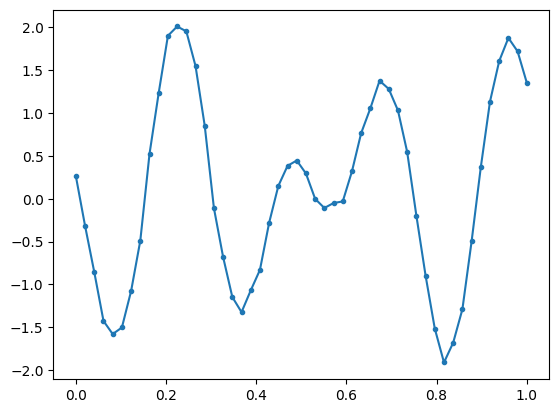

In [46]:
# 샘플 생성함수 테스트
# 샘플 하나는 (T, D) 형태
# 여기서 T: 타입스탭n_steps, D: 데이터의 차원
# 아래 코드는 샘플하나를 생성함

# 임의로 웨이브의 모양을 조정할 숫자를 샘플링
w1, w2, d1, d2 = np.random.rand(4)

# 웨이브 하나가 몇개의 점(스탭)으로 구성되는지 지정
n_steps = 50

# x는 (n_step,)인 1차원 어레이
x = np.linspace(0, 1, n_steps)

# eps 도  (n_step,)인 1차원 어레이
eps = np.random.rand(n_steps)

# w1, w2, d1, d2는 숫자
# y는 (n_step,)인 1차원 어레이
y = np.sin((10*w1 + 10)*(x - d1)) + np.sin((20*w2 + 20)*(x - d2)) + 0.2*eps

# 그릴때 마다 50개 점으로 구성된 웨이브가 달라짐
plt.plot(x, y, '.-')

plt.show()

- 위 셀에서 테스트한 웨이브 하나를 만드는 코드를 함수로 만들어 `(batch_size, n_steps)`를 지정하면 `n_steps`로 이뤄진 웨이브 `batch_size`개 만큼 만들어 `(batch_size, n_steps, 1)`인 데이터 셋을 리턴하게 합니다.

- 브로드캐스팅을 적극적으로 사용하는 코드로 이해가 쉽지 않기 때문에 주석을 자세히 읽어보길 바랍니다.

In [47]:
# 아래 코드를 이해 하기 위한 numpy broad castaing
# 위식 (x-d) 부분에 대해서만 실험
batch_size = 5
d = np.random.rand(batch_size,1) # (5,1)
x = np.linspace(0, 1, 3) # (3,)

x - d # (5, 3):(batch size, time step)

array([[-0.48468649,  0.01531351,  0.51531351],
       [-0.12826034,  0.37173966,  0.87173966],
       [-0.6443705 , -0.1443705 ,  0.3556295 ],
       [-0.20470622,  0.29529378,  0.79529378],
       [-0.74495713, -0.24495713,  0.25504287]])

In [48]:
# 샘플 생성 함수
# 출처: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
# 아래 함수는 위 셀에서 생성한 샘플 하나를 B개 만큼 생성해서
# (Batch size, Time step, D) 모양으로 되돌림
# D는 데이터의 차원이고 이 예에서는 D=1

def generate_time_series(batch_size, n_steps):
    # 한 미니배치 안에 들어 있는 샘플들은 모두 다른 freq와 offset값을 가지는
    # 모양이 상이한 웨이브들
    # w, d: (batch_size, 1)
    # 따라서 각 매개변수 w, d를 4개 만드는데 한개 당 batch_size만큼 길이로..
    # 그냥 (batch_size,)로 하지않고 (batch_size,1)로하는 건
    # 아래쪽에서 (x-d):(batch_size, n_step)과 곱할 때 n_step에 대해서 브로드캐스팅되게하기 위해
    # 즉, 1은 step의 차원이라 보면 됨
    w1, w2, d1, d2 = np.random.rand(4, batch_size, 1)
    # 각 웨이브 하나를 몇개의 점들로 구성할지 결정
    x = np.linspace(0, 1, n_steps) # (n_step,)

    # 계산 결과는 기본적으로 (batch_size, n_step)으로 만들고 마지막에 데이터 차원 1을 추가
    # x:(n_step,), w, d: (batch_size, 1),  series:(batch_size, n_step)
    series = 0.5 * np.sin( (10*w1 + 10) * (x - d1) ) # wave 1, (batch_size, n_step)
    series += 0.2 * np.sin( (20*w2 + 20) * (x - d2) ) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise (batch_size, n_step)

    # 마지막에 데이터 차원 1을 추가 (Batch size, Time step, D)
    return series[:, :, np.newaxis].astype(np.float32)

## 1\. T 타임스탭 이후 1개 값 예측

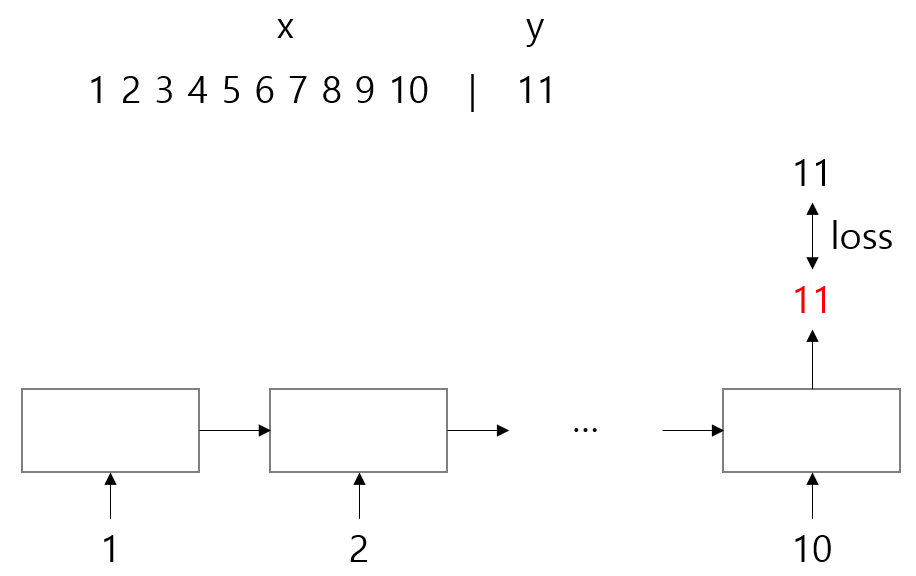

- 1~10 을 입력받아 11을 예측

### 샘플 생성

- 샘플 형태의 형태는 다음과 같이 구성됩니다.
    - `series`: (N, T+1, 1)
        - N은 샘플 개수
        - 마지막 1은 데이터의 차원
        - T+1은 T까지는 X, 마지막 1은 타겟
    - 이 `series`를 다음처럼 `X`, `y`로 나눕니다.
    - `X`: `(N, T, 1)`
    - `y`: `(N, 1)`

In [49]:
# 50+1 스탭으로 구성된 10000개 샘플을 무작위로 만듭니다.

np.random.seed(42)
N_sample = 10000

n_steps = 50
series = generate_time_series(N_sample, n_steps + 1)
 # n_steps + 1: 맞힐 값 합쳐서 n+1
series.shape

(10000, 51, 1)

In [50]:
# train, valid, test 셋으로 나눕니다.

X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [51]:
# 학습 세트의 모양 확인

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

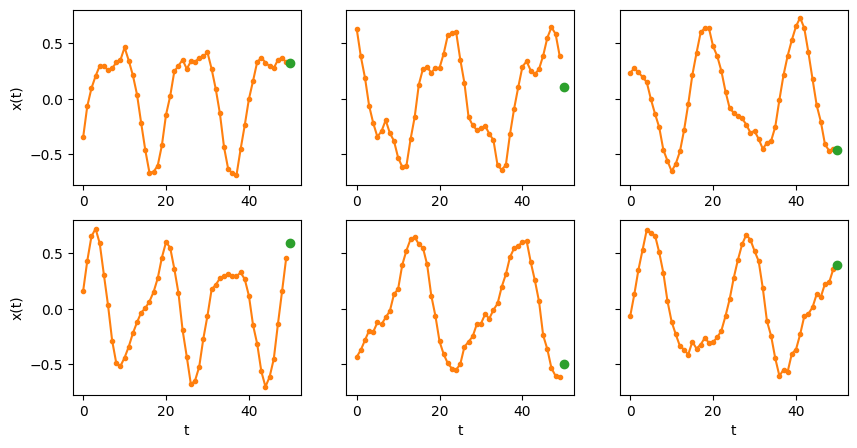

In [52]:
# 적당한 번호의 샘플부터 6개를 그려봅니다.
sample_idx = 101

fig, ax = plt.subplots(figsize=(10,5), nrows=2, ncols=3,
                        sharey=True, dpi=100)

for i, ax_i in enumerate(ax.flat):
    ax_i.plot(X_train[sample_idx+i], '.-', color='C1')
    ax_i.plot(X_train[0].shape[0], y_train[sample_idx+i], 'o', color='C2')
    ax_i.set_ylabel('x(t)' if i in [0, 3] else '')
    ax_i.set_xlabel('t' if i in [3,4,5] else '')

plt.show()

- 위 그림처럼 오렌지색 50개 포인트를 입력하여 마지막 초록색 포인트 값을 예측하는 문제를 풀게 됩니다.

### Dataset과 DataLoader

- 데이터 셋이 만들어졌으므로 모델이 데이터를 적재할 수 있도록 `Dataset`과 `DataLoader`를 준비합니다.

- 데이터의 생성은 좀 복잡했지만 데이터 자체는 매우 간단하므로 `Dataset`을 만드는 것도 크게 설명이 필요없이 직관적인 코드로 작성되었습니다.

In [53]:
# Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        series = self.X[idx]
        y = self.y[idx]

        return series, y

In [54]:
# 데이터 셋을 생성
D_train = TimeSeriesDataset(X_train, y_train)
D_valid = TimeSeriesDataset(X_valid, y_valid)
D_test = TimeSeriesDataset(X_test, y_test)

In [55]:
# 임의로 미니 배치 받아오는 테스트
X, y = D_train[100]

X.shape, y.shape

((50, 1), (1,))

In [56]:
# DataLoader 생성
train_loader = DataLoader(D_train, shuffle=True, batch_size=30)
valid_loader = DataLoader(D_valid, shuffle=False, batch_size=30)
test_loader = DataLoader(D_test, shuffle=False, batch_size=30)

### 모델 정의

- `Sequential`을 사용하여 모델을 정의 합니다.

- 순차적으로 `RNN`과 `Linear`를 배치합니다.

- 여기서도 `RNN`과 `Linear` 사이를 연결할 `ExtractLastCell` 사용자 정의 모듈이 필요합니다.

In [57]:
x

array([0. , 0.5, 1. ])

In [58]:
class ExtractLastCell(torch.nn.Module):
    def forward(self, x):
        # 여기서 x는 이전 층인 torch.nn.RNN에서 출력한 텐서
        # (output, hn)로 구성되어 있으므로 마지막 결과만 추출하여 반환
        out, hn = x
        return hn[0]

model_1 = torch.nn.Sequential(
        ################################################################
        # WRITE YOUR CODE HERE
        # 여기 순차적으로 레이어를 배치하세요.[+]
        # RNN은 hidden_size=56, batch_first=True로 설정하세요.
        # ExtractLastCell()을 적절한 순서에 위치시키세요.
        # y값을 예측할 것이므로 Linear의 출력은 1이 되어야 하고
        # 별도의 마지막 활성 함수는 필요 없습니다.
        torch.nn.RNN(input_size=1, hidden_size=56, batch_first=True),
        ExtractLastCell(),
        torch.nn.Linear(56, 1)
        ################################################################
    )

In [59]:
# Forward test
train_loader_iter = iter(train_loader)
X, y = next(train_loader_iter)
print('X: ', X.shape, 'y: ', y.shape)

y_pred = model_1(X)
print('y_pred: ', y_pred.shape)

X:  torch.Size([30, 50, 1]) y:  torch.Size([30, 1])
y_pred:  torch.Size([30, 1])


### 손실함수, 옵티마이저, hyper parameters

- 학습에 필요한 조건을 세팅합니다. 이번 작업은 시간 축을 따라 존재하는 실수값을 맞추는 문제이므로 손실은 `MSELoss`로 정의 합니다.

In [60]:
# epoch
epochs = 20

# batch_size
m = 64

# learning_rate
lr = 0.0001

criterion = torch.nn.MSELoss() # 회귀이므로 MSELoss
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)

### 학습

In [61]:
%%time

model_1.to(device)

for e in range(epochs):
    model_1.train()

    for i, d in enumerate(train_loader):
        X = d[0].to(device)
        y = d[1].to(device)

        optimizer.zero_grad()
        out = model_1(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    # train, test loss and acc.
    model_1.eval()
    with torch.no_grad():
        corr = 0
        loss_sum = 0.0
        for j, d in enumerate(train_loader):
            X = d[0].to(device)
            y = d[1].to(device)
            out = model_1(X) # (N, 10)
            loss = criterion(out, y)
            loss_sum += loss
        train_loss = loss_sum / (j+1)

        corr = 0
        loss_sum = 0.0
        for j, d in enumerate(valid_loader):
            X = d[0].to(device)
            y = d[1].to(device)
            out = model_1(X) # (N, 10) # log softmax
            loss = criterion(out, y)
            loss_sum += loss
        test_loss = loss_sum / (j+1)

    print(f"EPOCH:{e+1:3d}, Train Loss:{train_loss:.6f}, Valid Loss:{test_loss:.6f}")

EPOCH:  1, Train Loss:0.049452, Valid Loss:0.051845
EPOCH:  2, Train Loss:0.027707, Valid Loss:0.028243
EPOCH:  3, Train Loss:0.011291, Valid Loss:0.010976
EPOCH:  4, Train Loss:0.009618, Valid Loss:0.009439
EPOCH:  5, Train Loss:0.009431, Valid Loss:0.009296
EPOCH:  6, Train Loss:0.008200, Valid Loss:0.008122
EPOCH:  7, Train Loss:0.007899, Valid Loss:0.007768
EPOCH:  8, Train Loss:0.007247, Valid Loss:0.007073
EPOCH:  9, Train Loss:0.006732, Valid Loss:0.006651
EPOCH: 10, Train Loss:0.006380, Valid Loss:0.006312
EPOCH: 11, Train Loss:0.005945, Valid Loss:0.005892
EPOCH: 12, Train Loss:0.005590, Valid Loss:0.005525
EPOCH: 13, Train Loss:0.005334, Valid Loss:0.005309
EPOCH: 14, Train Loss:0.005096, Valid Loss:0.005038
EPOCH: 15, Train Loss:0.004906, Valid Loss:0.004864
EPOCH: 16, Train Loss:0.004721, Valid Loss:0.004644
EPOCH: 17, Train Loss:0.004501, Valid Loss:0.004445
EPOCH: 18, Train Loss:0.004316, Valid Loss:0.004294
EPOCH: 19, Train Loss:0.004197, Valid Loss:0.004152
EPOCH: 20, T

### 테스트 세트에 대해 확인

In [62]:
test_loader_iter = iter(test_loader)

# 임의의 테스트 배치에 대해서
test_batch = next(test_loader_iter)

# test_batch[0]은 batched X로 (30, 50, 1)
# test_batch[1]은 batched y로 (30, 1)
test_batch[0].shape, test_batch[1].shape

(torch.Size([30, 50, 1]), torch.Size([30, 1]))

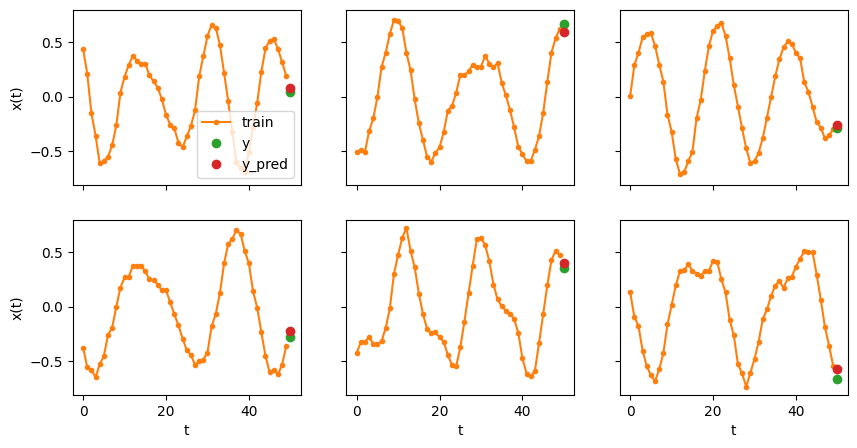

In [63]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, ncols=3,
                       sharex=True, sharey=True, dpi=100)

for i, ax_i in enumerate(ax.flat):
    # test_batch[0]은 batched X로 (30, 50, 1)
    # test_batch[1]은 batched y로 (30, 1)

    # 30개 샘플 중에 i번째 샘플을 로 잘라 오기 위해 슬라이싱 사용
    X = test_batch[0][i:i+1].to(device) # (1, 50, 1)
    y = test_batch[1][i].to(device)     # (1,)

    # (1,50,1)인 샘플 하나를 포워드 시킴
    y_pred = model_1(X) # (1,1)

    # 예측값을 저장하고 아래에서 빨간색으로 그림을 그림
    y_pred = y_pred.detach()

    ax_i.plot(X[0].cpu().numpy(), '.-', color='C1', label='train' if i == 0 else '')
    ax_i.plot(X[0].shape[0], y.cpu().numpy(), 'o', color='C2', label='y' if i == 0 else '')
    ax_i.plot(X[0].shape[0], y_pred.cpu().numpy(), 'o', color='C3', label='y_pred' if i == 0 else '')
    ax_i.set_ylabel('x(t)' if i in [0, 3] else '')
    ax_i.set_xlabel('t' if i in [3,4,5] else '')

    if i == 0 :
        ax_i.legend()

plt.show()

### 데이터 생성

- 이제 50개 포인트를 보고 이후 한개 포인트를 예측하는 모델을 만들었습니다.

- 이 모델로 무엇을 할 수 있을까요?

- 다음과 같은 과정으로 데이터를 생성할 수 있습니다.
    - 1번에서 50번까지 데이터를 보고 51번 데이터를 예측합니다.
    - 예측한 51번 데이터를 마지막에 추가하고 2번부터 51번을 보고 52번을 예측합니다.
    - 이런 과정을 계속 반복합니다.


- 위 과정에 대한 코드가 아래 제시되어 있습니다.

- 데이터의 모양과 예측하는 과정의 주석을 자세히 읽어보세요.

In [64]:
np.random.seed(43)

# 60스탭 데이터를 생성, (1, 60, 1)
GEN_SERIES = generate_time_series(1, n_steps + 10)

# 50개는 입력데이터로 사용하고
# 마지막 10개는 생성한 데이터가 얼마나 잘 맞는지 확인할 용도로 사용합니다.
# X_new: (1, 50, 1), Y_new: (1, 10, 1)
X_new, Y_new = GEN_SERIES[:, :n_steps], GEN_SERIES[:, n_steps:]

# 총 10번 예측
for step_ahead in range(10):
    # 50개에 대해서 한 포인트 예측 합니다.
    # 주석은 step_ahead == 0 인 첫번째 반복을 기준으로 작성되었습니다.

    X_tensor = torch.tensor(X_new[:, step_ahead:]).to(device) # (1, 50, 1)
    y_pred_one = model_1(X_tensor) # y_pred_one: (1, 1), (배치, y_dim)
    y_pred_one = y_pred_one.unsqueeze(1) # (1, 1*, 1), (배치, timestep*, y_dim)
    # 방금 예측한 y_pred_one을 새로운 샘플로 뒤에 추가
    X_new = np.concatenate([X_new, y_pred_one.detach().cpu().numpy()], axis=1) # (1, 51, 1)

# 이 시점에서 X: (1, 60, 1), X 끝에 10개는 예측한 포인트 10개
#             n_steps == 50
Y_pred_by_mode_1 = X_new[:, n_steps:] # (1, 10, 1) 50에서 59까지

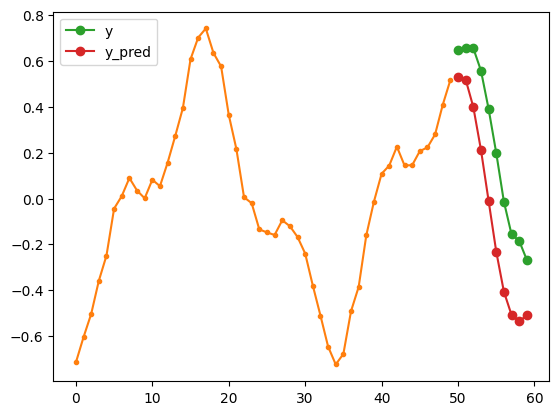

In [65]:
fig = plt.figure()
ax = plt.axes()

pred_step = Y_pred_by_mode_1.shape[1]

# 초기 입력 데이터
ax.plot(X_new[0,:n_steps, 0], '.-', color='C1')

# 실제 뒤 10스탭
ax.plot(np.arange(n_steps, n_steps + pred_step), Y_new[0].squeeze(),
        "o-", color='C2', label="y")

# 예측 뒤 10스탭
ax.plot(np.arange(n_steps, n_steps + pred_step), Y_pred_by_mode_1[0].squeeze(),
        "o-", color='C3', label="y_pred")
ax.legend()

plt.show()

## 2\. T 타입스탭 이후 10개 값 예측


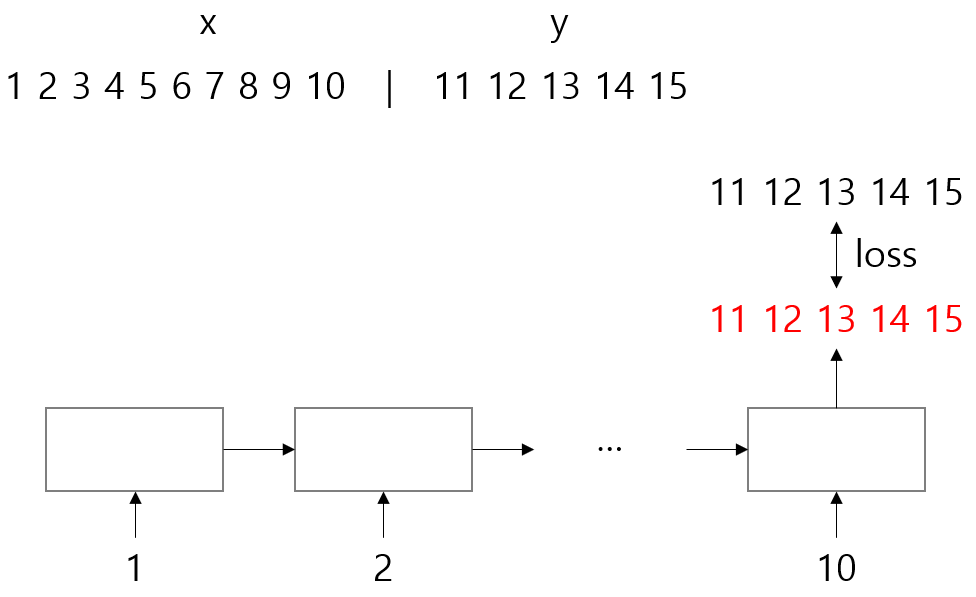


### 샘플 생성

- 지금까지 50개 입력값을 본 후 51번째 값을 예측하는 모델을 만들어 50개 값을 보고 51번째, 52번째, ..., 60번째 값을 예측하는 실험을 해봤습니다.

- 이렇게 한 타임스탭씩 예측하여 누적하는 방식이 아니라 한번에 10개 값을 예측하도록 학습 시킬 수 있습니다.

- 이를 위해 우선 학습 세트를 다음처럼 구성해야 합니다.

- 샘플 형태의 형태는 다음과 같이 구성됩니다.
    - `series`: (N, T+10, 1)
        - N은 샘플 개수
        - 마지막 1은 데이터의 차원
        - T+10은 T까지는 X, 마지막 10은 타겟
    - 이 `series`를 다음처럼 `X`, `y`로 나눕니다.
    - `X`: `(N, T, 1)`
    - `y`: `(N, 10)`

In [66]:
# 50+10 스탭으로 구성된 10000개 샘플을 무작위로 만듭니다.
np.random.seed(42)
N_sample = 10000

n_steps = 50
series = generate_time_series(N_sample, n_steps + 10)
series.shape

(10000, 60, 1)

In [67]:
# train, valid, test 셋으로 나눕니다.

X_train, y_train = series[:7000, :n_steps], series[:7000, n_steps:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:]
X_test, y_test = series[9000:, :n_steps], series[9000:, n_steps:]


In [68]:
# 학습 세트의 모양 확인

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 10, 1))

### Dataset과 DataLoader

In [69]:
# 데이터 셋을 생성
D_train = TimeSeriesDataset(X_train, y_train)
D_valid = TimeSeriesDataset(X_valid, y_valid)
D_test = TimeSeriesDataset(X_test, y_test)

# DataLoader 생성
train_loader = DataLoader(D_train, shuffle=True, batch_size=m)
valid_loader = DataLoader(D_valid, shuffle=True, batch_size=m)
test_loader = DataLoader(D_test, shuffle=True, batch_size=m)

In [70]:
# 임의로 미니 배치 받아오는 테스트
X, y = D_train[100]

X.shape, y.shape

((50, 1), (10, 1))

### 모델 정의

In [73]:
class ExtractLastCell(torch.nn.Module):
    def forward(self, x):
        out, hn = x
        # 여기서 x는 이전 층인 torch.nn.RNN에서 출력한 텐서
        # (output, hn)로 구성되어 있으므로 마지막 결과만 추출하여 반환
        return out[:, -1, :]

model_2 = torch.nn.Sequential(
        torch.nn.RNN(input_size=1, hidden_size=56, batch_first=True),
        ExtractLastCell(),
        torch.nn.Linear(56, 10),
    )

In [74]:
# Forward test
train_loader_iter = iter(train_loader)
X, y = next(train_loader_iter)
print('X: ', X.shape, 'y: ', y.shape)

y_pred = model_2(X)
print('y_pred: ', y_pred.shape)

X:  torch.Size([64, 50, 1]) y:  torch.Size([64, 10, 1])
y_pred:  torch.Size([64, 10])


### 손실함수, 옵티마이저, hyper parameters

In [75]:
# epoch
epochs = 20

# batch_size
m = 64

# learning_rate
lr = 0.0001

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)

### 학습

In [76]:
%%time

model_2.to(device)

for e in range(epochs):
    model_2.train()

    for i, d in enumerate(train_loader):
        X = d[0].to(device)
        y = d[1].to(device)

        optimizer.zero_grad()
        out = model_2(X).unsqueeze(-1) # (N, 10)->(N, 10, 1)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    # train, test loss and acc.
    model_2.eval()
    with torch.no_grad():
        corr = 0
        loss_sum = 0.0
        for j, d in enumerate(train_loader):
            X = d[0].to(device)
            y = d[1].to(device)
            out = model_2(X).unsqueeze(-1)  # (N, 10)->(N, 10, 1)
            loss = criterion(out, y)
            loss_sum += loss
        train_loss = loss_sum / (j+1)

        corr = 0
        loss_sum = 0.0
        for j, d in enumerate(valid_loader):
            X = d[0].to(device)
            y = d[1].to(device)
            out = model_2(X).unsqueeze(-1) # (N, 10) # log softmax
            loss = criterion(out, y)
            loss_sum += loss
        test_loss = loss_sum / (j+1)

    print(f"EPOCH:{e+1:3d}, Train Loss:{train_loss:.6f}, Valid Loss:{test_loss:.6f}")

EPOCH:  1, Train Loss:0.126109, Valid Loss:0.127213
EPOCH:  2, Train Loss:0.067660, Valid Loss:0.066959
EPOCH:  3, Train Loss:0.048867, Valid Loss:0.048422
EPOCH:  4, Train Loss:0.046370, Valid Loss:0.046362
EPOCH:  5, Train Loss:0.045637, Valid Loss:0.045606
EPOCH:  6, Train Loss:0.045105, Valid Loss:0.044868
EPOCH:  7, Train Loss:0.044827, Valid Loss:0.045005
EPOCH:  8, Train Loss:0.044047, Valid Loss:0.043819
EPOCH:  9, Train Loss:0.044295, Valid Loss:0.044238
EPOCH: 10, Train Loss:0.043165, Valid Loss:0.043234
EPOCH: 11, Train Loss:0.042211, Valid Loss:0.042098
EPOCH: 12, Train Loss:0.041663, Valid Loss:0.041433
EPOCH: 13, Train Loss:0.041229, Valid Loss:0.041037
EPOCH: 14, Train Loss:0.042156, Valid Loss:0.041845
EPOCH: 15, Train Loss:0.040127, Valid Loss:0.039911
EPOCH: 16, Train Loss:0.039739, Valid Loss:0.039462
EPOCH: 17, Train Loss:0.038927, Valid Loss:0.038687
EPOCH: 18, Train Loss:0.038241, Valid Loss:0.037946
EPOCH: 19, Train Loss:0.037507, Valid Loss:0.037052
EPOCH: 20, T

### 데이터 생성

- 이전 처럼 루프를 돌면서 하나씩 생성하지 않고 10개를 한번에 예측

In [77]:
np.random.seed(43)

# 50개는 입력데이터로 사용하고
# 마지막 10개는 생성한 데이터가 얼마나 잘 맞는지 확인할 용도로 사용합니다.
# X_new:(1,50,1), Y_new:(1,10,1)
X_new, Y_new = GEN_SERIES[:, :n_steps], GEN_SERIES[:, n_steps:]

X_tensor = torch.tensor(X_new).to(device) # (1, 50, 1)
print("input:", X_tensor.shape)

# 마지막 입력 이후 10개 포인트 예측
Y_pred_10_by_model_2 = model_2(X_tensor)
Y_pred_10_by_model_2 = Y_pred_10_by_model_2.detach().cpu().numpy()
print("Y_pred_10_by_model_2: ", Y_pred_10_by_model_2.shape)

input: torch.Size([1, 50, 1])
Y_pred_10_by_model_2:  (1, 10)


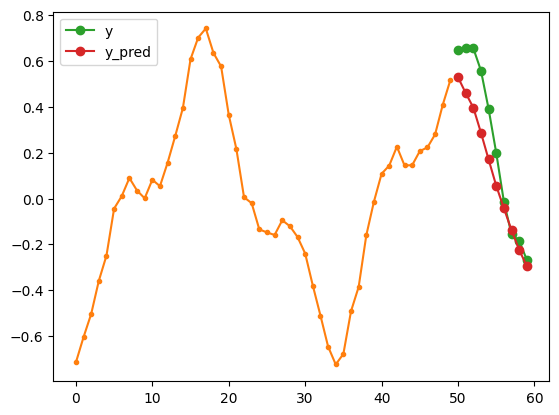

In [78]:
fig = plt.figure()
ax = plt.axes()

pred_step = Y_pred_10_by_model_2.shape[1]

ax.plot(X_new[0, :, 0], '.-', color='C1')
ax.plot(np.arange(n_steps, n_steps + pred_step), Y_new[0, :, 0], 'o-', color='C2', label="y")
ax.plot(np.arange(n_steps, n_steps + pred_step), Y_pred_10_by_model_2[0], 'o-', color='C3', label="y_pred")
ax.legend()

plt.show()

## 3\. 매 타입 스탭마다 이후 10개 값 예측

- 마지막으로 타입스탭 마다 이후 n개 값을 예측하는 모델을 생각해보겠습니다.

- 50개 값을 한 타임스탭 마다 하나씩 입력하고 마지막 단계에서 예측을 하는 것이 아니라 50개 값이 입력될 때 마다 입력된 값 다음 n개 값을 예측하는 방식입니다.

- 이런 방식이 좀 이상하게 느껴질지 모르나 그림을 보면 좀 더 명확하게 이해할 수 있습니다.

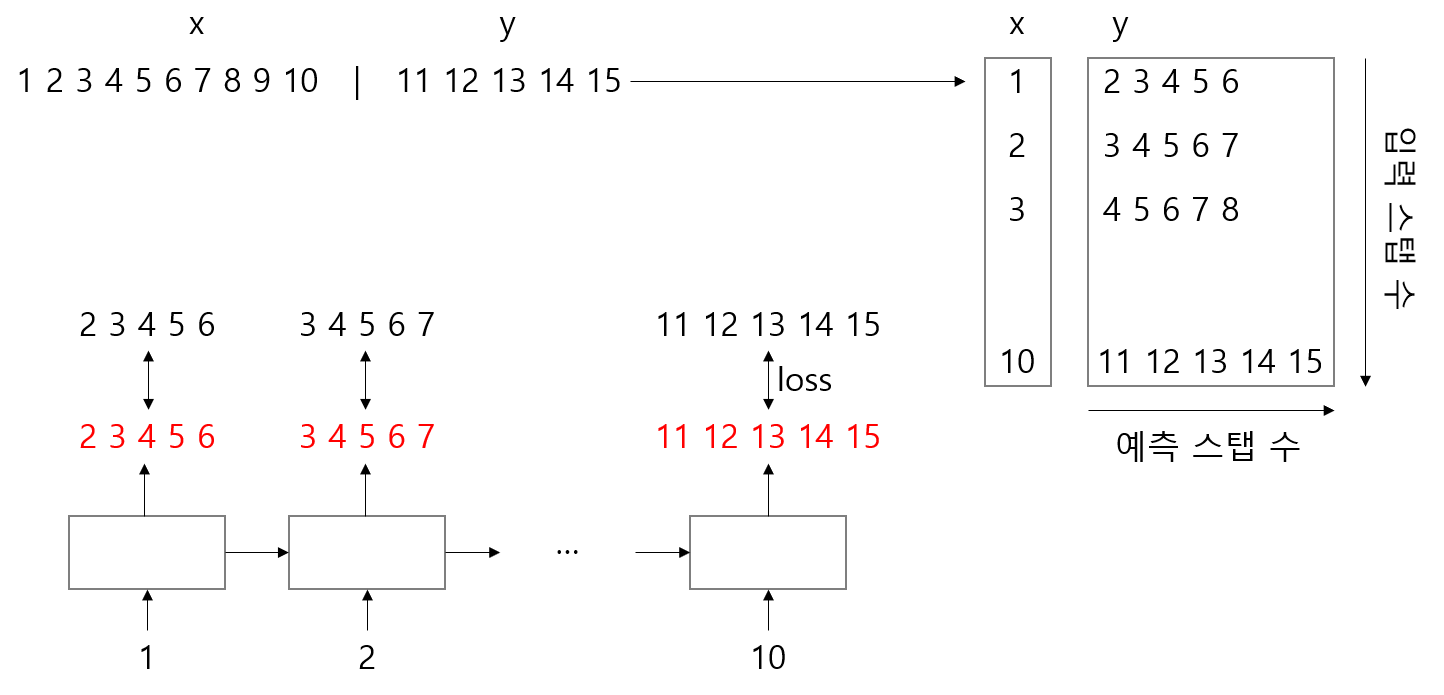

### 샘플 생성

- 위 그림이 지금 하고자 하는 작업을 잘 나타내고 있습니다.

- 1~10까지 10개 타입스탭에 대한 값을 입력하고 마지막 5개 값을 예측하는 문제를 생각해봅시다.

- 그림에서 11, 12, 13, 14, 15를 정확하게 예측하고 싶은 것입니다. `model_2`는  마지막 10이 입력되었을 때 예측하고자 하는 값 다섯개를 예측합니다.

- 하지만 10이 입력되기 이전 과정에서 입력된 숫자에 대해서 이후 5개 값을 예측하게 강제한다면 좀 더 강력한 지도 학습을 하게되는 셈입니다.

- 이를 위해 데이터를 그림처럼 가공해야 합니다.

- 이해를 위해 그림과 같은 토이 데이터 셋을 만들어 실험한 다음 전체 데이터셋에 적용하도록 하겠습니다.

In [79]:
toy_series = np.arange(1, 16).reshape(1,15,1)
toy_series

array([[[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15]]])

- 데이터를 다음처럼 만들 필요가 있습니다.

```
x:(1, 10, 1) y:(1, 10, 5)
1    ->      [ 2,  3,  4,  5,  6]
2    ->      [ 3,  4,  5,  6,  7]
3    ->      [ 4,  5,  6,  7,  8]
4    ->      [ 5,  6,  7,  8,  9]
5    ->      [ 6,  7,  8,  9, 10]
6    ->      [ 7,  8,  9, 10, 11]
7    ->      [ 8,  9, 10, 11, 12]
8    ->      [ 9, 10, 11, 12, 13]
9    ->      [10, 11, 12, 13, 14]
10   ->      [11, 12, 13, 14, 15]
```


- 입력의 모양은 지금과 동일하고 타겟만 달라지게 되는데 만들고자하는 타겟을 보면 세로 방향으로 2부터 시작해서 입력 스탭만큼 나열되고 그 다음 컬럼에 3부터 시작해서 다시 입력 스탭만큼 나열되는 식입니다.

- 즉 전체 샘플에서 1번 인덱스 부터 입력스탭만큼 잘라와서 대상 텐서의 컬럼에 값을 넣으면 됩니다.

- 간단한 연습후에 코드를 봅시다.

In [80]:
foo = np.zeros((7, 5))
bar = np.arange(1, 15)
print('foo\n', foo)
print('bar', bar)

# bar의 값중 임의의 위치에 있는 연속된 7개 값을 가져와
# foo의 3번 컬럼에 대입합니다.
foo[:,0] = bar[1:1+7]
foo[:,1] = bar[2:2+7]
foo[:,2] = bar[3:3+7]
foo[:,3] = bar[3:3+7]
foo[:,4] = bar[4:4+7]
foo

# foo에 들어있는 숫자의 패턴에 만들고자 하는 타겟 행렬과 같은가요?

foo
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
bar [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


array([[ 2.,  3.,  4.,  4.,  5.],
       [ 3.,  4.,  5.,  5.,  6.],
       [ 4.,  5.,  6.,  6.,  7.],
       [ 5.,  6.,  7.,  7.,  8.],
       [ 6.,  7.,  8.,  8.,  9.],
       [ 7.,  8.,  9.,  9., 10.],
       [ 8.,  9., 10., 10., 11.]])

- 위 샘플 코드를 이해했으면 아래 코드를 이해할기 어렵지 않을것입니다.

In [81]:
batch_size = 1
n_steps = 10
pred_steps = 5

Y_toy = np.zeros((batch_size, n_steps, pred_steps), dtype=np.float32)

for step_ahead in range(1, pred_steps + 1):
    Y_toy[:, :, step_ahead - 1] = toy_series[:, step_ahead:step_ahead + n_steps, 0]

Y_toy

array([[[ 2.,  3.,  4.,  5.,  6.],
        [ 3.,  4.,  5.,  6.,  7.],
        [ 4.,  5.,  6.,  7.,  8.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 6.,  7.,  8.,  9., 10.],
        [ 7.,  8.,  9., 10., 11.],
        [ 8.,  9., 10., 11., 12.],
        [ 9., 10., 11., 12., 13.],
        [10., 11., 12., 13., 14.],
        [11., 12., 13., 14., 15.]]], dtype=float32)

- 이제 실제 데이터 셋에 적용합시다.

In [82]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(N_sample, n_steps + 10)

Y = np.zeros((10000, n_steps, 10), dtype=np.float32)

for step_ahead in range(1, 10 + 1):
    Y[:,:,step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]


In [83]:
# train, valid, test 셋으로 나눕니다.

X_train, y_train = series[:7000, :n_steps], Y[:7000]
X_valid, y_valid = series[7000:9000, :n_steps], Y[7000:9000]
X_test, y_test = series[9000:, :n_steps], Y[9000:]


In [84]:
# 학습 세트의 모양 확인
# 입력 숫자 하나당 출력이 숫자 10개

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 50, 10))

### Dataset과 DataLoader

In [85]:
# 데이터 셋을 생성
D_train = TimeSeriesDataset(X_train, y_train)
D_valid = TimeSeriesDataset(X_valid, y_valid)
D_test = TimeSeriesDataset(X_test, y_test)

# DataLoader 생성
train_loader = DataLoader(D_train, shuffle=True, batch_size=m)
valid_loader = DataLoader(D_valid, shuffle=True, batch_size=m)
test_loader = DataLoader(D_test, shuffle=True, batch_size=m)

In [86]:
# 임의로 미니 배치 받아오는 테스트
X, y = D_train[100]

X.shape, y.shape

((50, 1), (50, 10))

### 모델 정의

In [88]:
class ExtractLastCell(torch.nn.Module):
    def forward(self, x):
        # RNN에서 되돌린 output:(N, L, Hout) (batch first인 경우)에서
        # 모든 타입스탭에 걸친 결과를 추출
        out, _  = x

        return out

model_3 = torch.nn.Sequential(
        # 여기 순차적으로 레이어를 배치하세요.
        # extraclastcell()을 적절한 순서에 위치시키세요.
        torch.nn.RNN(input_size=1, hidden_size=56, batch_first=True),
        ExtractLastCell(),
        torch.nn.Linear(56, 10),
    )

In [89]:
# Forward test
train_loader_iter = iter(train_loader)
X , y = next(train_loader_iter)
print('X: ', X.shape, 'y: ', y.shape)

y_pred = model_3(X)
print('y_pred:', y_pred.shape)

# 모든 타입스탭에 걸친 로스 구하기
loss = torch.nn.functional.mse_loss(y_pred, y)
loss.item()

X:  torch.Size([64, 50, 1]) y:  torch.Size([64, 50, 10])
y_pred: torch.Size([64, 50, 10])


0.15165755152702332

### 손실함수, 옵티마이저, hyper parameters

In [90]:
# epoch
epochs = 20

# batch_size
m = 64

# learning_rate
lr = 0.01

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=lr)

### 학습

In [91]:
%%time

model_3.to(device)

for e in range(epochs):
    model_3.train()

    for j, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model_3(X) # (N, 50, 10)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    # train, test loss and acc.
    model_3.eval()
    with torch.no_grad():
        corr = 0
        loss_sum = 0.0
        for j, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            out = model_3(X)
            loss = criterion(out, y)
            loss_sum += loss

        train_loss = loss_sum / (j+1)

        corr = 0
        loss_sum = 0.0
        for j, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            out = model_3(X)
            loss = criterion(out, y)
            loss_sum += loss

        test_loss = loss_sum / (j+1)

    print(f"EPOCH:{e+1:3d}, Train Loss:{train_loss:.6f}, Valid Loss:{test_loss:.6f}")

EPOCH:  1, Train Loss:0.044744, Valid Loss:0.044746
EPOCH:  2, Train Loss:0.042230, Valid Loss:0.042232
EPOCH:  3, Train Loss:0.034189, Valid Loss:0.034217
EPOCH:  4, Train Loss:0.031340, Valid Loss:0.031332
EPOCH:  5, Train Loss:0.031133, Valid Loss:0.031124
EPOCH:  6, Train Loss:0.028727, Valid Loss:0.028738
EPOCH:  7, Train Loss:0.026876, Valid Loss:0.026875
EPOCH:  8, Train Loss:0.024702, Valid Loss:0.024669
EPOCH:  9, Train Loss:0.023637, Valid Loss:0.023629
EPOCH: 10, Train Loss:0.023811, Valid Loss:0.023797
EPOCH: 11, Train Loss:0.022775, Valid Loss:0.022770
EPOCH: 12, Train Loss:0.020518, Valid Loss:0.020514
EPOCH: 13, Train Loss:0.022443, Valid Loss:0.022436
EPOCH: 14, Train Loss:0.020075, Valid Loss:0.020075
EPOCH: 15, Train Loss:0.020988, Valid Loss:0.021003
EPOCH: 16, Train Loss:0.018717, Valid Loss:0.018719
EPOCH: 17, Train Loss:0.019658, Valid Loss:0.019633
EPOCH: 18, Train Loss:0.018641, Valid Loss:0.018626
EPOCH: 19, Train Loss:0.018688, Valid Loss:0.018693
EPOCH: 20, T

### 데이터 생성

- `model_3`은 샘플 하나 `(1, 50, 1)`를 입력하면 50개 타임스탭에 대해서 모두 출력 10개를 생성하기 때문에 출력 모양이 `(1, 50, 10)`이 됩니다.

In [92]:
# X_new:(1,50,1), Y_new:(1,10,1)
X_new, Y_new = GEN_SERIES[:, :n_steps], GEN_SERIES[:, n_steps:]

X_tensor = torch.tensor(X_new).to(device)
print("input:", X_tensor.shape)

Y_pred_10_by_model_3 = model_3(X_tensor)
Y_pred_10_by_model_3 = Y_pred_10_by_model_3.detach().cpu().numpy()
print("Y_pred_10_by_model_3: ", Y_pred_10_by_model_3.shape)

input: torch.Size([1, 50, 1])
Y_pred_10_by_model_3:  (1, 50, 10)


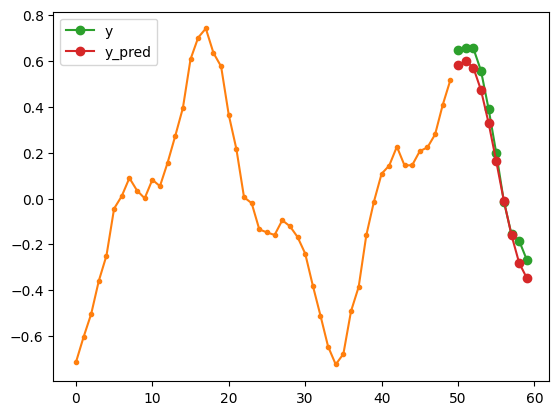

In [93]:
fig = plt.figure()
ax = plt.axes()

pred_step = Y_pred_10_by_model_3.shape[2]

ax.plot(X_new[0,:,0], '.-', color='C1')
ax.plot(np.arange(n_steps, n_steps + pred_step), Y_new[0,:,0], 'o-', color='C2', label="y")
ax.plot(np.arange(n_steps, n_steps + pred_step),
        Y_pred_10_by_model_3[0,-1], # 50개 타임스탭에 대한 예측 10개 중 마지막 타입스테 10개만 그림
        'o-', color='C3', label="y_pred")
ax.legend()

plt.show()

## 결과 비교

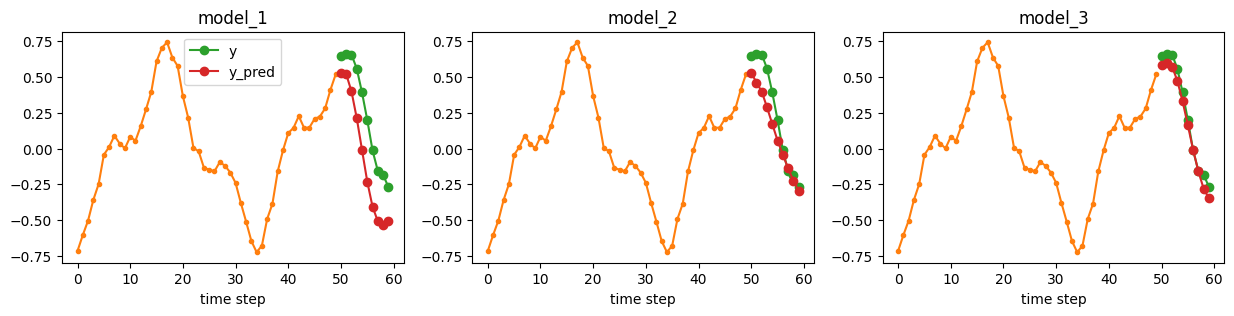

In [94]:
fig, ax = plt.subplots(figsize=(15,3), nrows=1, ncols=3)

pred_step = Y_pred_by_mode_1.shape[1]
ax[0].plot(X_new[0,:n_steps, 0], '.-', color='C1')
ax[0].plot(np.arange(n_steps, n_steps + pred_step), Y_new[0].squeeze(),
        "o-", color='C2', label="y")
ax[0].plot(np.arange(n_steps, n_steps + pred_step), Y_pred_by_mode_1[0].squeeze(),
        "o-", color='C3', label="y_pred")
ax[0].legend()
ax[0].set_xlabel('time step')
ax[0].set_title('model_1')

pred_step = Y_pred_10_by_model_2.shape[1]
ax[1].plot(X_new[0, :, 0], '.-', color='C1')
ax[1].plot(np.arange(n_steps, n_steps + pred_step), Y_new[0, :, 0], 'o-', color='C2', label="y")
ax[1].plot(np.arange(n_steps, n_steps + pred_step), Y_pred_10_by_model_2[0], 'o-', color='C3', label="y_pred")
# ax[1].legend()
ax[1].set_xlabel('time step')
ax[1].set_title('model_2')

pred_step = Y_pred_10_by_model_3.shape[2]
ax[2].plot(X_new[0,:,0], '.-', color='C1')
ax[2].plot(np.arange(n_steps, n_steps + pred_step), Y_new[0,:,0], 'o-', color='C2', label="y")
ax[2].plot(np.arange(n_steps, n_steps + pred_step),
        Y_pred_10_by_model_3[0,-1], # 50개 타임스탭에 대한 예측 10개 중 마지막 타입스테 10개만 그림
        'o-', color='C3', label="y_pred")
# ax[2].legend()
ax[2].set_xlabel('time step')
ax[2].set_title('model_3')

plt.show()